# M07 - Caracterización y Agrupación de Usuarios en Redes Sociales mediante Análisis de Mensajes

Grupo 3:

>- Juan Pablo Baudoin


# Análisis exploratorio

In [66]:
import matplotlib.pyplot as plt
import matplotlib

import numpy as np
import pandas as pd
import seaborn as sns
import emoji
import io
import chardet
from unidecode import unidecode
# from pycountry import languages
# from langid.langid import LanguageIdentifier, model

from lib.utils import *
from lib.sim import *

from pandarallel import pandarallel

pandarallel.initialize()
sns.set(rc={'figure.figsize':(10,6)})
pd.set_option('display.max_rows', 10) # cambiar el número de filas que se mostrarán usando display.max_rows.

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [67]:
# upgrade pip
#! pip install --upgrade pip -q
#! pip install emoji pandarallel matplotlib numpy pandas chardet unidecode
# ! pip install seaborn -q
#! pip install networkx -q
#! pip install langdetect -q
# ! pip install scipy -q
# ! pip install scikit-learn -q



## 1. Lectura de datos

In [68]:
base_name = "signals_langs"
src_ds = f"data/{base_name}.csv"
df_ori = pd.read_csv(src_ds)
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936272 entries, 0 to 936271
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       936272 non-null  int64  
 1   commodity                751982 non-null  object 
 2   source_posted_at         936272 non-null  object 
 3   trade_type               935079 non-null  object 
 4   chat_id                  934972 non-null  float64
 5   telegram_user_id         936272 non-null  int64  
 6   message_text             936233 non-null  object 
 7   message_text_translated  451354 non-null  object 
 8   language                 896118 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 64.3+ MB


In [69]:
df_ori.rename(columns={'username':'telegram_user_id'}, inplace=True)

# Creamos una columna id con el índice de la tabla
df_ori['id_msg'] = df_ori.index


In [70]:
df_ori

,id,commodity,source_posted_at,trade_type,chat_id,telegram_user_id,message_text,message_text_translated,language,id_msg
0,2001,DOGE,2022-10-29 17:45:19+00,sell,765.0,1923710,CAPTION: Abercrombie&Fitch || Up to $90 - Rest...,NaN,en,0
1,2001,DOGE,2022-10-29 17:45:19+00,sell,1040.0,1420790,sometimes I forget BNB and XRP exist,sometimes I forget BNB and XRP exist,no,1
2,2001,DOGE,2022-10-29 17:45:19+00,sell,3396.0,2673772,Check the basics of Tron here https://steemit....,NaN,en,2
3,2001,DOGE,2022-10-29 17:45:19+00,sell,3408.0,3078883,سلام کد دعوت mexc بدید,"Hello, give mexc invitation code",ur,3
4,2001,DOGE,2022-10-29 17:45:19+00,sell,3720.0,3280159,"Check out the VIP section, how you can get it",NaN,en,4
...,...,...,...,...,...,...,...,...,...,...
936267,1098398,NaN,2022-04-04 18:13:52+00,buy,3205.0,3924802,"✅We are an Indian game payment company, big co...",NaN,en,936267
936268,1098410,TRX,2022-01-25 19:07:15+00,buy,3205.0,3970642,🔥五洲钱庄，外汇白资上浮收U🔥\n\n全网总代，高价收U， 长期可做。\n\n🎇承接USDT...,NaN,en,936268
936269,1098228,NaN,2022-02-14 16:06:05+00,NaN,3205.0,4325620,大量下浮出U，同台交易，下浮一毛5。联系飞机 @zhanggechuu168,"A large number of Us are floating down, tradin...",vi,936269
936270,1098206,NaN,2022-02-17 20:25:57+00,NaN,3205.0,4325620,大量下浮出U，同台交易，下浮一毛5。联系飞机 @zhanggechuu168,"A large number of Us are floating down, tradin...",vi,936270


In [71]:
# check if a file exists
import os
# Vamos a trabajar con una copia de los datos y generamos un archivo nuevo en el que adicionaremos 
# las columnas con información adicional.
work_file = f"data/{base_name}_enhanced.csv"
if not os.path.exists(work_file):
    print(f"Creating {work_file}")
    df_ori.to_csv(work_file, index=False)
    df = df_ori.copy()
else:
    print(f"File {work_file} already exists. Loading it.")
    df = pd.read_csv(work_file)
    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])



Creating data/signals_langs_enhanced.csv


## 2. Análisis de datos categóricos y texto
En una primera revisión vamos a ver:
- Valores nulos
- Frecuencias de variables categóricas: commodity, trade_type, chat_id, telegram_user_id
- Análisis del campo message_text: mediante una inspección de datos muestral se ve que existen varios idiomas, que se tienen múltiples encodings y se detecta el uso de emojis. Comportamiento esperado en mensajes de canales de chat en aplicaciones como telegram o whatsapp. Para el análisis del campo message_text, generaremos información adicional sobre el mismo:
  * Idioma
  * longitud caracteres
  * Numero de palabras
  * Cantidad de saltos de linea
  * Encodings



In [72]:
# group df by id and count the number of rows
df_grouped_id = df.groupby('id').size().reset_index(name='counts')
# sort the values by counts
df_grouped_id = df_grouped_id.sort_values(by='counts', ascending=False)
df_grouped_id

,id,counts
71320,170667,967
70812,170144,870
71104,170445,555
71068,170407,551
70842,170174,546
...,...,...
104060,205680,1
96615,197699,1
109028,210965,1
116888,219310,1


### 2.1 Nulos

In [73]:
# get the percentage of missing values in the dataset
missing_values = df_ori.isnull().mean() * 100
# sort the columns by the percentage of missing values
missing_values = missing_values.sort_values(ascending=False)

filter_columns = missing_values > 0

print("############")
print("Columns with missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}: {percentage:.2f}%")


filter_columns = missing_values == 0
print("############")
print("Columns with no missing values")
for column, percentage in  missing_values[filter_columns].items():
    print(f"    {column}")

############
Columns with missing values
    message_text_translated: 51.79%
    commodity: 19.68%
    language: 4.29%
    chat_id: 0.14%
    trade_type: 0.13%
    message_text: 0.00%
############
Columns with no missing values
    id
    source_posted_at
    telegram_user_id
    id_msg


In [74]:
# Excluir los registros sin chat_id
df = df.dropna(subset=['chat_id'])
df = df.dropna(subset=['message_text'])
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 934933 entries, 0 to 936271
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       934933 non-null  int64  
 1   commodity                751937 non-null  object 
 2   source_posted_at         934933 non-null  object 
 3   trade_type               933740 non-null  object 
 4   chat_id                  934933 non-null  float64
 5   telegram_user_id         934933 non-null  int64  
 6   message_text             934933 non-null  object 
 7   message_text_translated  450656 non-null  object 
 8   language                 894779 non-null  object 
 9   id_msg                   934933 non-null  int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 78.5+ MB


In [75]:
# Remove rows when  chat_id is equal NaN
df = df[df['chat_id'].notna()].copy()

In [76]:
# convert chat_id to integer
df['chat_id'] = df['chat_id'].astype(int)

## Filtado de mensajes en ingles

In [77]:
# List the languages in the datase language column
languages = df['language'].unique()
print(languages)


['en' 'no' 'ur' 'ar' 'pt' nan 'fa' 'da' 'fr' 'so' 'af' 'ru' 'nl' 'fi' 'bg'
 'sw' 'tr' 'bn' 'sv' 'id' 'sl' 'vi' 'et' 'it' 'hr' 'de' 'es' 'ca' 'zh-tw'
 'tl' 'pl' 'sq' 'cy' 'lt' 'hu' 'ro' 'sk' 'cs' 'uk' 'mk' 'lv' 'hi' 'he'
 'mr' 'te' 'ja' 'th' 'ne' 'ta' 'unknown' 'ml' 'el' 'gu' 'kn']


In [78]:
# filter the messages with language 'en'
# flt_en = df['language'] == 'en'
flt_en = df['language'] == 'en'
df = df[flt_en]

print(f"Numero de mensajes en ingles: {df.shape[0]}")

Numero de mensajes en ingles: 445265


### 2.2. Frecuencias simples

#### 2.2.1. Top 10 de conteos

In [79]:
### Frecuencia de variables categóricas
print_top(df, 'commodity', "Currency", top=11)
print("--------")

print_top(df, 'chat_id', "Canal", top=11)
print("--------")

print_top(df, 'telegram_user_id', "Users", top=11)
print("--------")

print_top(df, 'trade_type', "Tipo Operación", top=11)
print("--------")


Top 11 Currency (commodity):
01 - N/A: 89170 	 (20.03%  - 20.03%) 	 (NaN)
02 - BTC: 18192 	 (4.09%  - 24.12%) 	 (W/NaN 5.11% - 5.11%)
03 - ETH: 11180 	 (2.51%  - 26.63%) 	 (W/NaN 3.14% - 8.25%)
04 - LTC: 7017 	 (1.58%  - 28.21%) 	 (W/NaN 1.97% - 10.22%)
05 - DYDX: 4655 	 (1.05%  - 29.26%) 	 (W/NaN 1.31% - 11.53%)
06 - BNB: 4234 	 (0.95%  - 30.21%) 	 (W/NaN 1.19% - 12.72%)
07 - ATOM: 3606 	 (0.81%  - 31.02%) 	 (W/NaN 1.01% - 13.73%)
08 - MATIC: 3582 	 (0.8%  - 31.82%) 	 (W/NaN 1.01% - 14.74%)
09 - DOGE: 3498 	 (0.79%  - 32.61%) 	 (W/NaN 0.98% - 15.72%)
10 - AXS: 3453 	 (0.78%  - 33.39%) 	 (W/NaN 0.97% - 16.69%)
11 - GALA: 3382 	 (0.76%  - 34.15%) 	 (W/NaN 0.95% - 17.64%)
--------
Top 11 Canal (chat_id):
01 - 765: 43835 	 (9.84% - 9.84%)
02 - 277: 42925 	 (9.64% - 19.48%)
03 - 3739: 34819 	 (7.82% - 27.30%)
04 - 313: 32040 	 (7.2% - 34.50%)
05 - 3720: 27353 	 (6.14% - 40.64%)
06 - 3243: 14258 	 (3.2% - 43.84%)
07 - 3396: 13501 	 (3.03% - 46.87%)
08 - 2985: 11787 	 (2.65% - 49.52%)
09 - 3

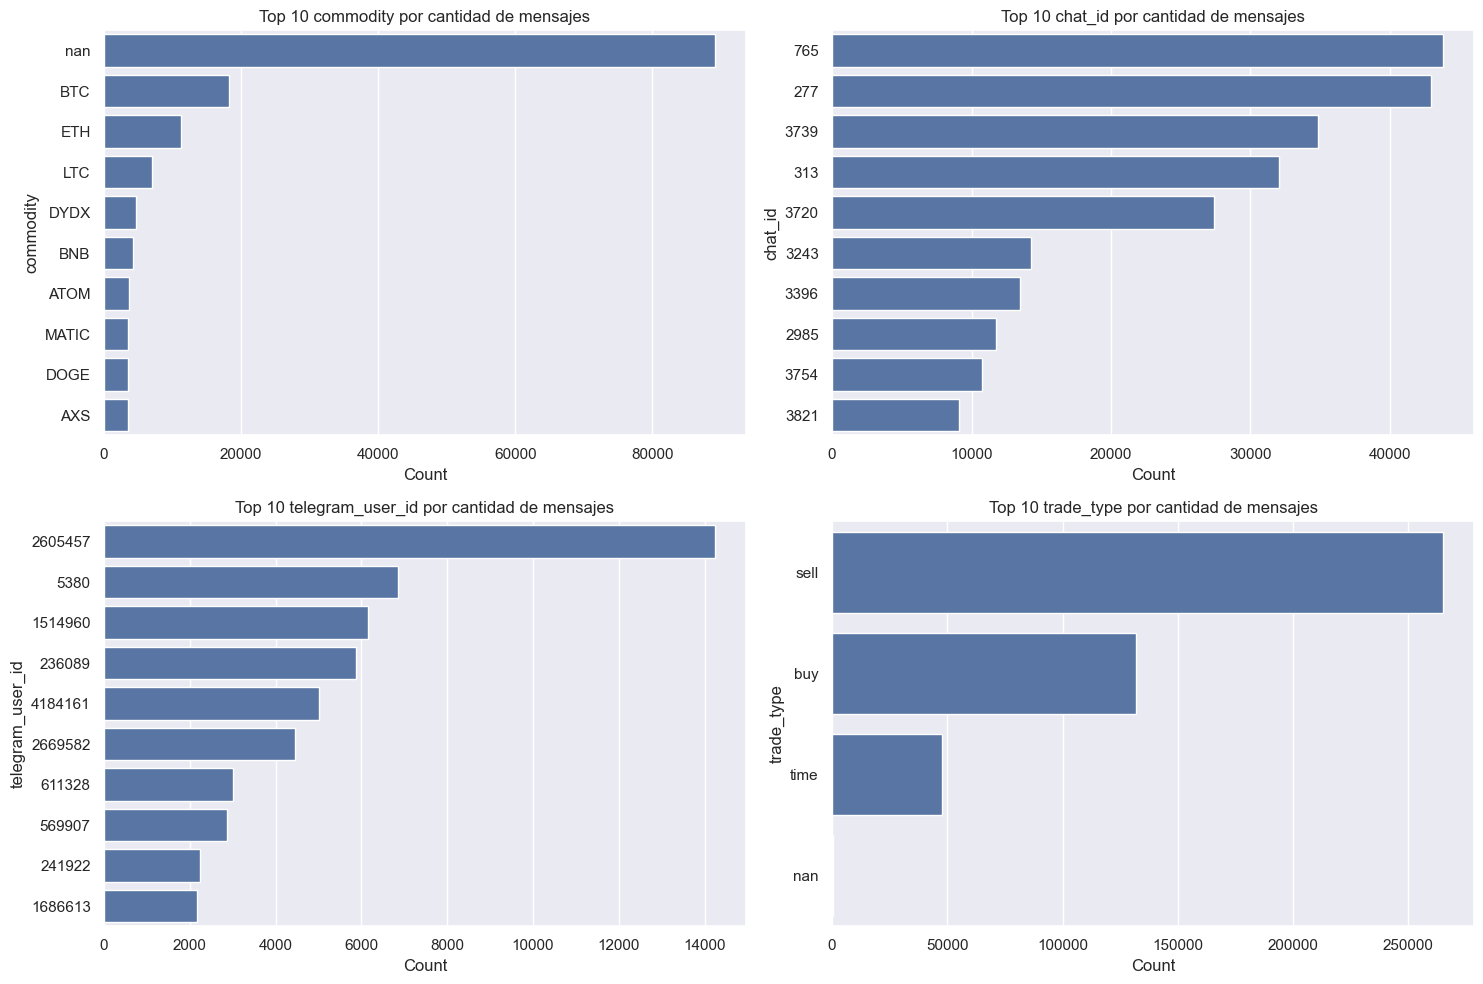

In [80]:
columns_to_plot = ['commodity', 'chat_id', 'telegram_user_id', 'trade_type']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    value_counts = df[column].astype(str).value_counts(dropna=False).head(10)
    
    # Convert value_counts to a DataFrame
    value_counts_df = value_counts.reset_index()
    value_counts_df.columns = [column, 'count']
    
    # Create the barplot
    sns.barplot(data=value_counts_df, x='count', y=column, ax=axes[i], orient='h')
    axes[i].set_title(f'Top 10 {column} por cantidad de mensajes')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(column)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.2.2. Cruce de variables `telegram_user_id` y `chat_id`

In [81]:
# count the number of chat_ids
chat_ids = df['chat_id'].nunique()
print(f"Number of chat_ids: {chat_ids}")

# count the number of users
users = df['telegram_user_id'].nunique()
print(f"Number of users: {users}")



Number of chat_ids: 1622
Number of users: 66217


In [82]:
# Canales con un solo usuario
chat_users = df.groupby('chat_id')['telegram_user_id'].nunique()
chat_users = chat_users.sort_values(ascending=False)
single_user_chats = chat_users[chat_users == 1]
print(f"Number of chats with a single user: {single_user_chats.count()} ({single_user_chats.count()/chat_ids:.2%})")


# Usuarios con un solo canal
user_chats = df.groupby('telegram_user_id')['chat_id'].nunique()
user_chats = user_chats.sort_values(ascending=False)
single_chat_users = user_chats[user_chats == 1]
print(f"Number of users with a single chat: {single_chat_users.count()} ({single_chat_users.count()/users:.2%})")


# Distribucion de numero de mensajes por canal


Number of chats with a single user: 1220 (75.22%)
Number of users with a single chat: 63898 (96.50%)


In [83]:
# Canales con más de un usuario sort by number of users
multi_user_chats = chat_users[chat_users > 1]

print(f"Number of chats with more than one user: {multi_user_chats.count()}")
print(f"Number of chats with more than one user: {multi_user_chats.count()/chat_ids:.2%}")
print(multi_user_chats)

print("--------")

# Usuarios con más de un canal
multi_chat_users = user_chats[user_chats > 1]
print(f"Number of users with more than one chat: {multi_chat_users.count()}")
print(f"Number of users with more than one chat: {multi_chat_users.count()/users:.2%}")
print(multi_chat_users)




Number of chats with more than one user: 402
Number of chats with more than one user: 24.78%
chat_id
3739    10402
277      8128
3720     7366
3396     6200
3821     2308
        ...  
423         2
422         2
426         2
296         2
931         2
Name: telegram_user_id, Length: 402, dtype: int64
--------
Number of users with more than one chat: 2319
Number of users with more than one chat: 3.50%
telegram_user_id
5380       58
241922     30
172966     15
2628616     8
2628777     7
           ..
573275      2
3835052     2
3639049     2
2848285     2
1303662     2
Name: chat_id, Length: 2319, dtype: int64


### 2.3. Análisis del campo message_text
#### 2.3.1. Limpieza de datos y enriquecimiento simple

Para continuar con el análisis exploratorio, como indicamos antes, necesitamos realizar una limpieza y enriequecimiento de datos inicial. Vamos a proceder a adicionar las siguientes columnas:
- date_source_posted_at: transformación del campo date_source a formato fecha
- message_text_clean: aplicar las siguentes transformaciones al message_text
    - Clean_lbr: consolidar saltos de linea repetidos en uno solo
    - Clean emojis: Remover los emojis
- message_text_clean_utf8: convertir message_text_clean a encoding utf8, cuando no sea utf8 o ascii.
- message_length: Contar los caracteres de linea de message_text_clean_utf8
- message_words: Contar las palabras en el campo message_text_clean_utf8
- message_lbr: Contar los salos de linea de message_text_clean_utf8
- message_encoding2: identificar el encoding de message_text_clean_utf8


In [84]:
def clean_lbr(text):
    # Replace continuous line breaks with a single line break

    # df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply
    # (lambda x: '\n'.join(line.strip() for line in x.splitlines() if line.strip()))

    try:
        cleaned_text = '\n'.join(line.strip() for line in text.splitlines() if line.strip())
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text
    

In [88]:
import re

def remove_special_characters(text):
    try: 
        # Remove special characters
        cleaned_text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)
        # trim leading and trailing spaces
        cleaned_text = cleaned_text.strip()
        # Replace continuous spaces with a single space
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    except Exception as e:
        print(text, type(text))
        print(e)
        cleaned_text = text
        raise e
    return cleaned_text


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 445265 entries, 586854 to 452459
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       445265 non-null  int64              
 1   commodity                356095 non-null  object             
 2   source_posted_at         445265 non-null  object             
 3   trade_type               444798 non-null  object             
 4   chat_id                  445265 non-null  int64              
 5   telegram_user_id         445265 non-null  int64              
 6   message_text             445265 non-null  object             
 7   message_text_translated  1170 non-null    object             
 8   language                 445265 non-null  object             
 9   id_msg                   445265 non-null  int64              
 10  date_source_posted_at    445265 non-null  datetime64[ns, UTC]
 11  message_text_

In [91]:

# def remove_emojis_tmp(text):
#     try:
#         cleaned_text = emoji.replace_emoji(text, '')
#     except Exception as e:
#         print(text, type(text))
#         print(e)
#         cleaned_text = text
#         raise e
#     return cleaned_text


In [96]:
force_process = False

if 'message_length' not in df.columns or force_process :

    df['date_source_posted_at'] = pd.to_datetime(df['source_posted_at'])

    # sort the data by chat_id and date_source_posted_at
    df = df.sort_values(by=['chat_id', 'date_source_posted_at'])

    ### Limpieza sobre el encoding original de los mensajes ###
    ###########################################################

    # Eliminar emojis y añadir columna message_no_emoji
    print("Cleaning Emojis")
    df['message_text_clean'] = df['message_text'].parallel_apply(remove_emojis).str.strip().str.lower()
    
    
    
    print("Cleaning Commodities")
    flt = df['commodity'].notnull()
    df.loc[flt, 'commodity_clean'] = df[flt]['commodity'].parallel_apply(remove_emojis).str.strip().str.lower()
    df.loc[flt, 'commodity_clean'] = df[flt]['commodity_clean'].parallel_apply(remove_special_characters)

    
    # # Detect the encoding of messages in the field message_text_clean of type string\
    print("Detecting encoding")
    df['message_encoding'] = df['message_text_clean'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])


    ### Limpieza sobre el encoding utf8 ###
    #######################################
    df['message_text_clean_utf8'] = df['message_text_clean']

    # # convert the all the messages to utf-8 where the encoding is different form utf-8
    print("Convert to utf-8")
    flt = df['message_encoding'] != 'utf-8'
    df.loc[flt, 'message_text_clean_utf8'] = df[flt]['message_text_clean'].apply(lambda x: unidecode(x))

    # print("Detecting encoding on new utf-8 messages")
    # df['message_encoding2'] = df['message_text_clean_utf8'].parallel_apply(lambda x: chardet.detect(x.encode())['encoding'])

    # Trim and remove multiple line breaks
    print("Cleaning LBR")
    df['message_text_clean_utf8'] = df['message_text_clean_utf8'].parallel_apply(clean_lbr)

    # Añadir columna con la longitud del mensaje sin emojis
    print("Checking message length")
    df['message_length'] = df['message_text_clean_utf8'].str.len()

    # Añadir columna con el número de palabras
    print("Checking message words")
    df['message_words'] = df['message_text_clean_utf8'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df['message_lbr'] = df['message_text_clean_utf8'].parallel_apply(count_line_breaks)

    print("Store the processed data")
    df.to_csv(work_file, index=False)


Cleaning Emojis
Cleaning Commodities
Detecting encoding
Convert to utf-8
Cleaning LBR
Checking message length
Checking message words
Checking message LBRs
Store the processed data


In [97]:
# find messages with a length of 0
zero_length = df['message_length'] == 0
print(f"Number of messages with a length of 0: {zero_length.sum()}")

# drop messages with a length of 0
df = df[~zero_length]
df.to_csv(work_file, index=False)


Number of messages with a length of 0: 0


#### 2.3.3. Mensajes duplicados

In [98]:
# Find duplicated messages 
duplicated_messages = df[df.duplicated(subset=['message_text_clean_utf8'], keep=False)]
duplicated_messages = duplicated_messages.sort_values(by=['message_text_clean_utf8'])
print(f"Number of duplicated messages: {duplicated_messages.shape[0]}")
# percentage of duplicated messages
print(f"Percentage of duplicated messages: {duplicated_messages.shape[0]/df.shape[0]:.2%}")
print("--------")


Number of duplicated messages: 191703
Percentage of duplicated messages: 43.05%
--------


In [99]:
duplicated_messages.head(5)['id_msg']

202248    202248
450603    450603
569735    569735
222152    222152
778088    778088
Name: id_msg, dtype: int64

Si vemos mensajes duplicados en una ventana pequeña de tiempo podemos asumir que son el mismo mensaje y quedarnos con uno.

In [100]:
# repeated_window
repeated_window = 1 # Window where to consider repeated messages within the same chat_id a repeated messaged

df = df.sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at'])

# Group by chat_id and find the time difference between consecutive messages
# df['time_diff'] = df.groupby('chat_id', 'message_text_clean_utf8')['date_source_posted_at'].diff()
df['time_diff'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['date_source_posted_at'].diff( )


# Mark duplicates as those with a time difference less than 5 minutes (300 seconds) and the same message text
df['duplicates'] = df['message_text_clean_utf8'].duplicated(keep=False)
df['duplicate_count'] = df.groupby(['chat_id', 'message_text_clean_utf8'])['id_msg'].transform('count')
df['duplicates_near'] = (df['time_diff'] <= pd.Timedelta(minutes=repeated_window)) & (df['message_text_clean_utf8'].duplicated(keep='first'))
# df['duplicates_near2'] = ((df['time_diff'].dt.total_seconds()/60) <= repeated_window) & (df['message_text_clean_utf8'].duplicated(keep='first'))


cols_check = ['chat_id', 'date_source_posted_at', 'message_text_clean_utf8', 'time_diff', 'duplicates', 'duplicates_near', 'duplicate_count']


# Keep only the first message in the case of duplicates
# df_filtered = df[~df['duplicate']]

# Drop helper columns if not needed
# df_filtered = df_filtered.drop(columns=['time_diff', 'duplicate'])

# count the number of duplicates_near
duplicates_near = df['duplicates_near'].sum()
print(f"Number of duplicates_near: {duplicates_near}")
print(f"Percentage of duplicates_near: {duplicates_near/df.shape[0]:.2%}")

flt_duplicates = df['duplicates']
df[flt_duplicates][cols_check].sort_values(by=['chat_id', 'message_text_clean_utf8', 'date_source_posted_at']).head(600).tail(10)

Number of duplicates_near: 9069
Percentage of duplicates_near: 2.04%


,chat_id,date_source_posted_at,message_text_clean_utf8,time_diff,duplicates,duplicates_near,duplicate_count
441682,5,2022-05-18 07:40:24+00:00,amazing one more quick profit for vip members ...,6 days 18:08:51,True,False,6
441694,5,2022-05-18 07:40:24+00:00,amazing one more quick profit for vip members ...,0 days 00:00:00,True,True,6
196590,5,2022-03-04 22:02:56+00:00,amazing one more quick profit for vip members ...,NaT,True,False,2
196598,5,2022-03-04 22:02:56+00:00,amazing one more quick profit for vip members ...,0 days 00:00:00,True,True,2
895806,5,2022-08-26 12:30:16+00:00,another big profit for vip's,NaT,True,False,2
895810,5,2022-08-26 12:30:16+00:00,another big profit for vip's,0 days 00:00:00,True,True,2
895051,5,2022-08-26 12:35:47+00:00,another profit for vip holders,NaT,True,False,2
895193,5,2022-08-26 12:35:47+00:00,another profit for vip holders,0 days 00:00:00,True,True,2
759999,5,2022-08-28 10:45:51+00:00,another profit for vip members in few days,NaT,True,False,2
760074,5,2022-08-28 10:45:51+00:00,another profit for vip members in few days,0 days 00:00:00,True,True,2


In [101]:
# Remove duplicates_near
df = df[~df['duplicates_near']]

work_file = f"data/{base_name}_enhanced_nodup.csv"
df.to_csv(work_file, index=False)

#### 2.3.4. Longitudes de texto
En esta revisión trabajaremos con las columnas de logitudes de texto adionadas:
- message_length
- message_lbr
- message_words

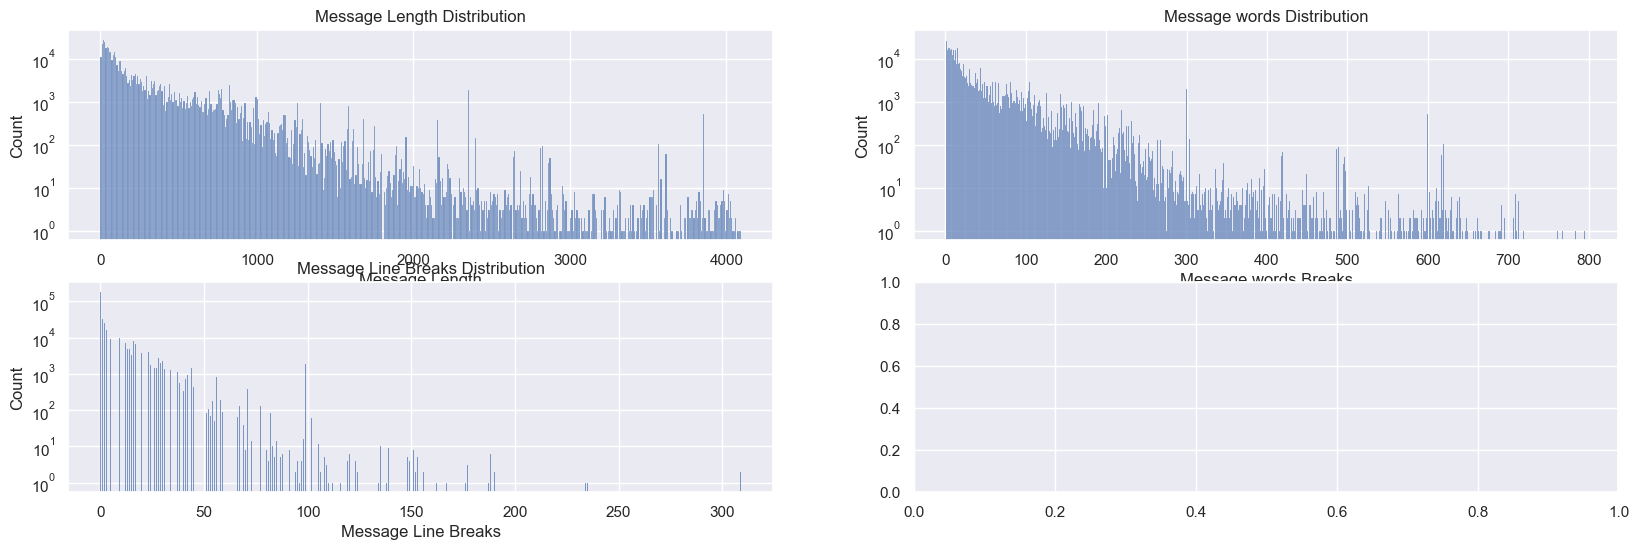

In [102]:
# Generate a distribution plots for message_length and message_lbr
# the plots should one next to the other
# we need to be able to set the size of the plots
# the plots should have a title
# the plots should have labels for the x and y axis

fig, axs = plt.subplots(2, 2, figsize=(20, 6))
sns.histplot(data=df, x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

sns.histplot(data=df, x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

sns.histplot(data=df, x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

Como es esperable, hay una alta concentración de mensajes cortos, pocas palabras y saltos de linea.
Revisaremos más de cerca los datos con valores abitrarios para hacer un rango más acotado. Vemos que existen outliers en todas las distribuciones, los cuales podríamos analizar en más detalle.

In [103]:
df[['message_length', 'message_words', 'message_lbr']].describe()

,message_length,message_words,message_lbr
count,436196.000000,436196.000000,436196.000000
mean,271.049205,41.294514,7.450373
std,404.832121,60.380047,13.628714
min,1.000000,1.000000,0.000000
25%,42.000000,7.000000,0.000000
50%,107.000000,17.000000,1.000000
75%,338.000000,51.000000,10.000000
max,4093.000000,797.000000,309.000000


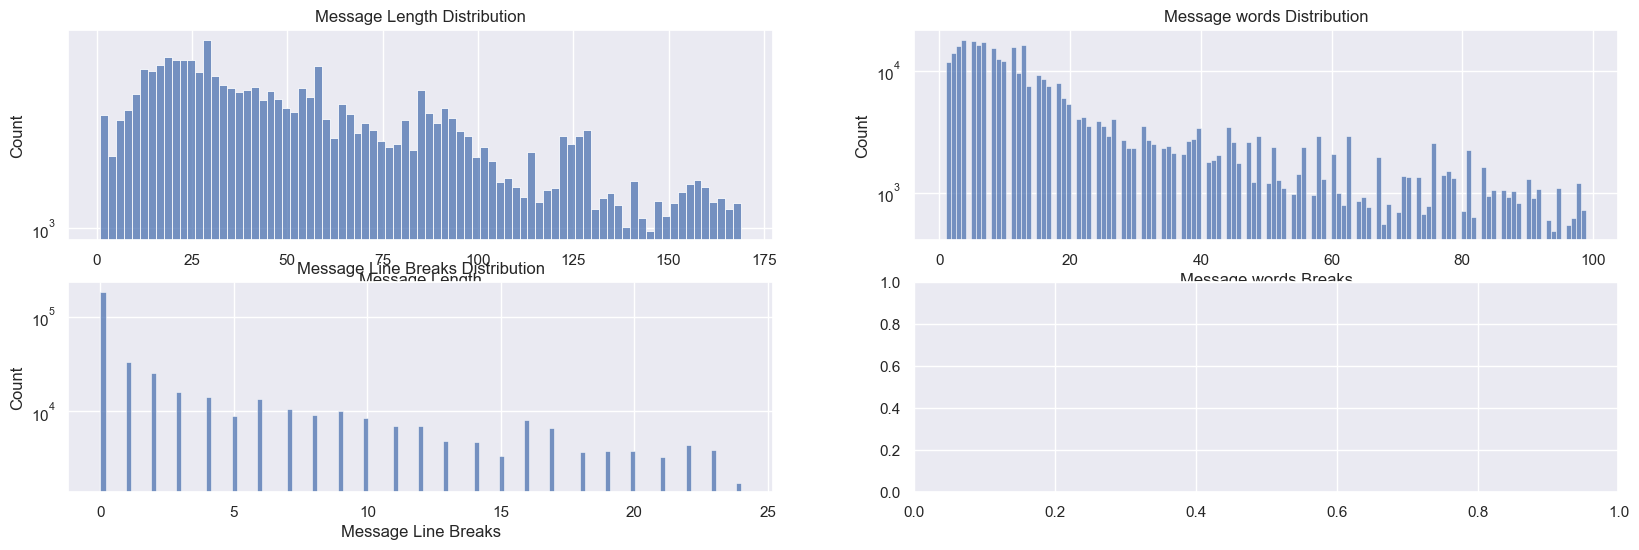

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(20, 6))

flt_ml = df['message_length'] < 170
sns.histplot(data=df[flt_ml], x='message_length', ax=axs[0,0])
axs[0,0].set_title('Message Length Distribution')
axs[0,0].set_xlabel('Message Length')
axs[0,0].set_ylabel('Count')
axs[0,0].set_yscale('log')

flt_mw = df['message_words'] < 100
sns.histplot(data=df[flt_mw], x='message_words', ax=axs[0,1])
axs[0,1].set_title('Message words Distribution')
axs[0,1].set_xlabel('Message words Breaks')
axs[0,1].set_ylabel('Count')
axs[0,1].set_yscale('log')

flt_mbr = (df['message_lbr'] < 25) & (df['message_lbr'] >= 0) 
sns.histplot(data=df[flt_mbr], x='message_lbr', ax=axs[1,0])
axs[1,0].set_title('Message Line Breaks Distribution')
axs[1,0].set_xlabel('Message Line Breaks')
axs[1,0].set_ylabel('Count')
axs[1,0].set_yscale('log')

plt.show()

In [105]:
print_top(df, 'message_lbr', "LBR", top=5)

Top 5 LBR (message_lbr):
01 - 0: 184547 	 (42.31% - 42.31%)
02 - 1: 33699 	 (7.73% - 50.04%)
03 - 2: 25431 	 (5.83% - 55.87%)
04 - 3: 16117 	 (3.69% - 59.56%)
05 - 4: 14241 	 (3.26% - 62.82%)


In [108]:
print_top(df, 'message_words', "Words", top=5)

Top 5 Words (message_words):
01 - 4: 17899 	 (4.1% - 4.10%)
02 - 5: 17544 	 (4.02% - 8.12%)
03 - 7: 17033 	 (3.9% - 12.02%)
04 - 13: 16380 	 (3.76% - 15.78%)
05 - 6: 16075 	 (3.69% - 19.47%)


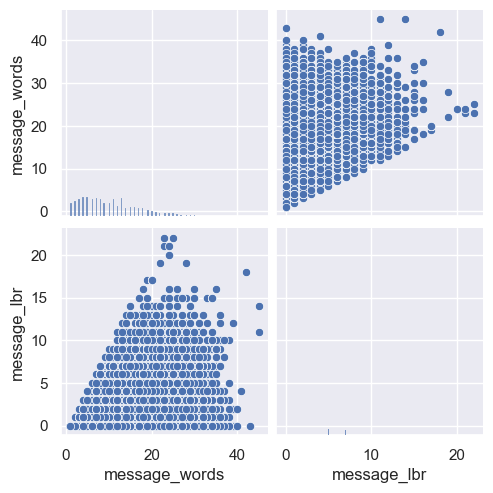

In [109]:
flt = flt_ml & flt_mw & flt_mbr
sns.pairplot(data=df[flt][['message_words', 'message_lbr']])
plt.show()

## Preprocesamiento vectorización

Para la comparación de mensajes es necesario vectorizar los mismos, este proceso requiere de una limpieza de datos adicional.

In [110]:
# Instalación de las bibliotecas necesarias
import os
import nltk
# import spacy
import pandas as pd
import re
import networkx as nx
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [111]:
df_sim = df

In [112]:
def create_word_bins(df, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
                               10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 
                               20, 21, 22, 23, 24, 25, 26, 27, 28, 29, np.inf]):
    """
    Function to bin the word count into categories.
    You can modify 'bins' based on your use case.
    """
    # Create a new column 'word_bin' based on the number of words
    df['word_bin'] = pd.cut(df['message_words'], bins=bins, labels=False, right=False)
    return df

In [113]:

stop_words = set(nltk.corpus.stopwords.words('english'))

def preprocess(text, stop_words=stop_words):

    text = text.lower()
    # tokenizar el texto
    text = text.replace('\n', ' LBRMARK ')

    
    text_tokens = word_tokenize(text)
    # replace numbers with a placeholder
    # print(text_tokens)
    text_tokens_rst = text_tokens.copy() 
    i = -1
    for token in text_tokens:
        i += 1
        token = re.sub(r'\s+', ' ', token)

        if token in stop_words:
            # remove the token from the list
            text_tokens_rst.pop(i)
            i -= 1
            # text_tokens_rst[i] = '{STOP_WORD}'
            continue

        if is_number(token):
            text_tokens_rst[i] = '{NUM}'
            continue

        if is_date(token):
            text_tokens_rst[i] = '{DATE}'
            continue

        tmp_token = re.sub(r'[^a-zA-Z0-9@\s]', ' ', token)  # eliminar caracteres especiales
        if tmp_token == token:
            continue
        text_tokens_rst[i] = preprocess(tmp_token)

    text = ' '.join(text_tokens_rst)
    # print(text)

    # text = re.sub(r'[^a-zA-Z0-9@\s]', ' ', text)  # eliminar caracteres especiales
    # remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # print(text)

    text = text.replace(' LBRMARK ', '\n')
    text = text.replace('LBRMARK', '\n')
    text = clean_lbr(text)
    return text


# df['tokenized_nltk'] = df['cleaned'].apply(word_tokenize)

# aclarar que se usa un dataset expandido
# Evolucion temporal con los meses con más mensajes
# conteo de users y chat_ids
# Mensajes por tipo de operación




In [114]:
# nltk.download('punkt_tab')


In [115]:
force_process = True

if 'cleaned_sim' not in df_sim.columns or force_process:
    df_sim.rename(columns={'message_lbr': 'message_lbr_utf8'}, inplace=True)
    df_sim.rename(columns={'message_words': 'message_words_utf8'}, inplace=True)

    print("Cleaning messages")
    # # apply preprocess to the messages df_sim['message_text_clean_utf8']
    df_sim['cleaned_sim'] = df_sim['message_text_clean_utf8'].apply(preprocess)
    

    # Añadir columna con el número de palabras
    print("Checking message words")
    df_sim['message_words'] = df_sim['cleaned_sim'].parallel_apply(lambda x: len(x.split()))

    # Añadir columna con el número de saltos de línea
    print("Checking message LBRs")
    df_sim['message_lbr'] = df_sim['cleaned_sim'].parallel_apply(count_line_breaks)

    print("Creating word bins")
    df_sim = create_word_bins(df_sim)



Cleaning messages
Error checking date with: 6114172758m
signed integer is greater than maximum
Error checking date with: 6006491614109629746:0708
signed integer is greater than maximum
Error checking date with: 6006491614097847730:7917
signed integer is greater than maximum
Error checking date with: 6006491614115473931:3890
signed integer is greater than maximum
Error checking date with: 6006491614078897142:7516
signed integer is greater than maximum
Error checking date with: 6006491614089677384:9177
signed integer is greater than maximum
Error checking date with: 6006491614102651200:8747
signed integer is greater than maximum
Error checking date with: 6006491614084973804:5433
signed integer is greater than maximum
Error checking date with: 6006491614098519775:8573
signed integer is greater than maximum
Error checking date with: 6006491614098254910:0608
signed integer is greater than maximum
Error checking date with: 6006491614096392704:7889
signed integer is greater than maximum
Error

In [121]:
#filter the messages with a length of 0
no_words = df_sim['message_words'] == 0
print(f"Messages with no words: {no_words.sum()}")

# drop messages with no words
df_sim = df_sim[~no_words]

Messages with no words: 2905


In [179]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433292 entries, 760412 to commodity_in_message
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       433291 non-null  float64            
 1   commodity                345960 non-null  object             
 2   source_posted_at         433291 non-null  object             
 3   trade_type               432858 non-null  object             
 4   chat_id                  433291 non-null  float64            
 5   telegram_user_id         433291 non-null  float64            
 6   message_text             433291 non-null  object             
 7   message_text_translated  1126 non-null    object             
 8   language                 433291 non-null  object             
 9   id_msg                   433291 non-null  float64            
 10  date_source_posted_at    433291 non-null  datetime64[ns, UTC]
 11 

In [125]:
# Add a colum to check  if cleaned_sim contains commodity_clean
# filter commodities with no nan values
df['commodity_in_message'] = df.apply(
    lambda row: row['commodity_clean'] in row['cleaned_sim'] if pd.notnull(row['commodity_clean']) else False,
    axis=1
)



In [135]:
# get the list of comooodities without nan values
commodities = df['commodity_clean'].unique()
commodities = commodities[~pd.isnull(commodities)]
commodities = commodities.tolist()

# convert the commodities to lower case
commodities = [commodity.lower() for commodity in commodities]

commodities
# Remove commodities with length <3
commodities = [commodity for commodity in commodities if len(commodity) > 2]

# remove commodities in the list of stop words
stop_words = ['...']
commodities = [commodity for commodity in commodities if commodity not in stop_words]

# commodities

In [138]:
df_sim = df_sim.copy()

In [144]:

# print(df)

In [302]:
# # filter cleaned_sim that start with 'breakout coin' or 'coin name'
# phrases = ['breakout coin :', 'coin name :', 'usdt']

# # Filter rows where cleaned_sim contains any of the specified phrases
# # flt = df_sim['cleaned_sim'].str.contains('|'.join(phrases), case=False, na=False)
# # filter by message_lbr > 10 < 20
# flt = (df_sim['message_lbr'] > 10) & (df_sim['message_lbr'] < 20)
# filtered_df = df_sim[flt]

# top = 250
# filtered_df[cols].head(top).tail(10)
# # .shape[0]
# #loop through filtered_df and print cleaned_sim	message_text_clean_utf8	matched_commodities	matched_commodities2
# for index, row in filtered_df[cols].head(top).tail(10).iterrows():
#     print("="*25)
#     # print(row['cleaned_sim'])
#     print(row['message_text_clean_utf8'])
#     print("--------")
#     print(row['trade_type'])
#     print(row['matched_exchanges'])
#     print(row['matched_commodities2'])

#     print("="*25)




In [259]:
import requests
import json

exchange_file = 'data/exchanges.json'
if not os.path.exists(exchange_file):
    url = "https://api.coingecko.com/api/v3/exchanges"
    response = requests.get(url)
    exchanges = response.json()
    # write the exchanges to a file
    with open(exchange_file, 'w') as f:
        json.dump(exchanges, f)
else:
    with open(exchange_file, 'r') as f:
        exchanges = json.load(f)

exchanges_names = [remove_emojis(exchange['name'].lower()) for exchange in exchanges] 


crypto_file = 'data/crypto_list.json'
if not os.path.exists(crypto_file):
    url = "https://api.coingecko.com/api/v3/coins/list"
    response = requests.get(url)
    crypto_list = response.json()
    # write the crypto_list to a file
    with open(crypto_file, 'w') as f:
        json.dump(crypto_list, f)
else:
    with open(crypto_file, 'r') as f:
        crypto_list = json.load(f)

crypto_list_names = [remove_emojis(crypto['symbol'].lower()) for crypto in crypto_list]
crypto_list_names = [commodity for commodity in list(set(crypto_list_names)) if len(commodity) > 2]
# get the list of exchanges


In [297]:
pattern_exchange = re.compile(r'\b(' + '|'.join(re.escape(exchange) for exchange in exchanges_names) + r')\b', re.IGNORECASE)

def find_exchange(text):
    try:
        exchanges = pattern_exchange.findall(text)
        if len(exchanges) == 0:
            return np.nan
    except Exception as e:
        print(text, type(text))
        print(e)
        exchanges = np.nan
        raise e
    return exchanges

df_sim['matched_exchanges'] = df_sim['cleaned_sim'].parallel_apply(lambda x: find_exchange(x))


In [276]:

# Regex pattern

def find_commodity2(text):
    
    pattern = re.compile(r"(\b\w+?)(?=[/]?(usdt|btc|eth)\b)")
    try:
        matches = pattern.findall(text)
        if len(matches) == 0:
            return np.nan
        extracted_matches = [match[0] for match in matches]
        # remove trailing _ and - from the extracted matches
        extracted_matches = [re.sub(r'[-_]+$', '', match) for match in extracted_matches]

    except Exception as e:
        print(text, type(text))
        print(e)
        exchanges = np.nan
        raise e
    return extracted_matches



df_sim['matched_commodities2'] = df_sim['message_text_clean_utf8'].parallel_apply(lambda x: find_commodity2(x))



In [277]:
pattern_comm = re.compile(r'\b(' + '|'.join(re.escape(commodity) for commodity in crypto_list_names) + r')\b', re.IGNORECASE)

def find_commodity(text):
    # remove NUM and DATE
    text = re.sub(r'{NUM}', '', text)
    text = re.sub(r'{DATE}', '', text)
    

    try:
        exchanges = pattern_comm.findall(text)
        if len(exchanges) == 0:
            return np.nan
    except Exception as e:
        print(text, type(text))
        print(e)
        exchanges = np.nan
        raise e
    return exchanges

df_sim['matched_exchanges'] = df_sim['cleaned_sim'].parallel_apply(lambda x: find_exchange(x))


In [303]:

cols = ['cleaned_sim', 'message_text_clean_utf8', 'matched_commodities','matched_commodities2', 'matched_exchanges', 'trade_type', 'message_words', 'message_lbr']
flt =(~df_sim['matched_commodities2'].isnull())
flt = flt | (~df_sim['matched_exchanges'].isnull())
flt = flt | (df_sim['trade_type'] == 'time')
df_sim_flt = df_sim[flt]



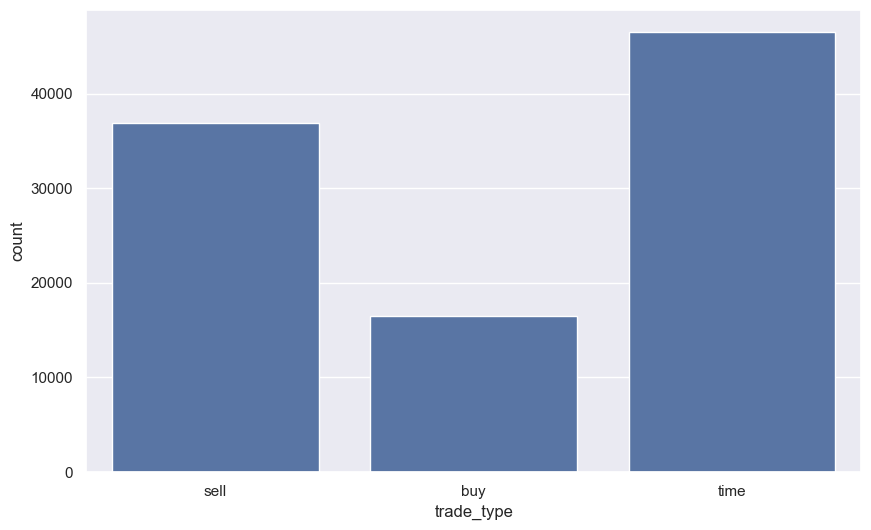

In [304]:
# barplot of trade_type
sns.countplot(data=df_sim_flt, x='trade_type')
plt.show()


In [305]:
print("Store the processed data")
work_file = f"data/{base_name}_pre-processed.csv"
df_sim_flt.to_csv(work_file, index=False)


Store the processed data
